In [1]:
!pip install astro-datasets numpy matplotlib albumentations

     |████████████████████████████████| 9.4 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 123 kB 56.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 53.8 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 49.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 36.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 48.4 MB/s eta 0:00:01
     |████████████████████████████████| 295 kB 52.6 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 49.9 MB/s eta 0:00:01
     |████████████████████████████████| 701 kB 52.0 MB/s eta 0:00:01
     |████████████████████████████████| 14.0 MB 29.0 MB/s eta 0:00:01
     |████████████████████████████████| 33.8 MB 30.0 MB/s eta 0:00:01
     |████████████████████████████████| 48.3 MB 23.9 MB/s eta 0:00:01
     |████████████████████████████████| 110 kB 53.7 MB/s eta 0:00:01
     |████████████████████████████████| 140 kB 51.6 MB/s eta 0:00:01
     |█████████████████████████

In [2]:
import numpy as np
import time, sys, os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import astro_datasets
import matplotlib.pyplot as plt
import albumentations as alb

2022-11-21 13:33:44.073981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(cmd_train, cmd_test, cmd_val), info = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'Nbody_IllustrisTNG', 'field': 'Mtot', 
                                                 'parameters': ['sigma8']})

2022-11-21 13:33:46.582434: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/Nbody_IllustrisTNG_Mtot_sigma8/cmd/1.0.4.incompleteZA625A/cmd-train.tfreco…

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/Nbody_IllustrisTNG_Mtot_sigma8/cmd/1.0.4. Subsequent calls will reuse this data.


2022-11-21 13:38:02.050371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 13:38:02.578446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78935 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:44:00.0, compute capability: 8.0


In [4]:
(simba_train, simba_test, simba_val), info_simba = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'Nbody_SIMBA', 'field': 'Mtot', 
                                                 'parameters': ['sigma8']})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/Nbody_SIMBA_Mtot_sigma8/cmd/1.0.4.incomplete3HH2A9/cmd-train.tfrecord*...:…

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/Nbody_SIMBA_Mtot_sigma8/cmd/1.0.4. Subsequent calls will reuse this data.


In [5]:
# define preprocessing, normalization and augmentation functions

def normalize(image, label):  
    image = tf.math.asinh(image)
    image = image - 26
    return image, label

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[256, 256])
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image],\
                                Tout=tf.float32)
    return aug_img, label

def set_shapes(img, label, img_shape=(256, 256, 1)):
    img.set_shape(img_shape)
    label.set_shape(1,)
    return img, label

# Define augmentation pipeline

transforms = alb.Compose([alb.VerticalFlip(p=0.6),
                          alb.HorizontalFlip(p=0.6),
                          alb.RandomRotate90(p=0.6)])


In [6]:
btch_size = 128

In [7]:
cmd_train = cmd_train.repeat(count=3) # increase dataset size
cmd_train = cmd_train.map(process_data)
cmd_train = cmd_train.map(set_shapes)
cmd_train = cmd_train.map(normalize)
cmd_train = cmd_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_test = cmd_test.map(normalize)
cmd_test = cmd_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_val = cmd_val.map(normalize)
cmd_val = cmd_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
simba_test = simba_test.map(normalize)
simba_test = simba_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
H = 7

In [10]:
#design CNN architecture
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same', input_shape=(256, 256, 1)),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(128*H, kernel_size=4, strides=1, padding = 'valid'),  
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64*H),
  tf.keras.layers.LeakyReLU(0.2), 
  tf.keras.layers.Dropout(0.2),  
  tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 14)      140       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 14)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 14)      1778      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 14)     56        
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 14)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 14)      798       
                                                        

In [11]:
opt = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)

In [12]:
#compile model, set the optimiser and the loss as defined above 
model.compile(optimizer=opt,
              loss='mae',
              metrics=['mse'])

In [13]:
epochs = 50

In [14]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1,
                                                 save_best_only=True)

model.fit(cmd_train, epochs=epochs, 
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True), reduce_lr, cp_callback], 
          validation_data=cmd_val)

Epoch 1/50


2022-11-21 13:42:14.135252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-11-21 13:42:16.307439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-21 13:42:16.554077: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9f1c009c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-21 13:42:16.554132: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2022-11-21 13:42:16.559988: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-21 13:42:16.707243: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

317/317 [==============================] - ETA: 0s - loss: 0.3170 - mse: 0.3368
Epoch 1: val_loss improved from inf to 2.25739, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 119s 329ms/step - loss: 0.3170 - mse: 0.3368 - val_loss: 2.2574 - val_mse: 9.5480 - lr: 0.0010
Epoch 2/50
317/317 [==============================] - ETA: 0s - loss: 0.1205 - mse: 0.0438
Epoch 2: val_loss improved from 2.25739 to 0.11063, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 103s 325ms/step - loss: 0.1205 - mse: 0.0438 - val_loss: 0.1106 - val_mse: 0.0666 - lr: 0.0010
Epoch 3/50
317/317 [==============================] - ETA: 0s - loss: 0.0855 - mse: 0.0218
Epoch 3: val_loss did not improve from 0.11063
317/317 [==============================] - 101s 318ms/step - loss: 0.0855 - mse: 0.0218 - val_loss: 0.1372 - val_mse: 0.0244 - lr: 0.0010
Epoch 4/50
317/317 [==============================] - ETA: 0s - loss: 0.0719 - mse: 0.0154
Epoch 4: val_loss improved from 0.11063 to 0.07046, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 103s 324ms/step - loss: 0.0719 - mse: 0.0154 - val_loss: 0.0705 - val_mse: 0.0275 - lr: 0.0010
Epoch 5/50
317/317 [==============================] - ETA: 0s - loss: 0.0616 - mse: 0.0105
Epoch 5: val_loss improved from 0.07046 to 0.05270, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 103s 325ms/step - loss: 0.0616 - mse: 0.0105 - val_loss: 0.0527 - val_mse: 0.0059 - lr: 0.0010
Epoch 6/50
317/317 [==============================] - ETA: 0s - loss: 0.0560 - mse: 0.0099
Epoch 6: val_loss did not improve from 0.05270
317/317 [==============================] - 97s 304ms/step - loss: 0.0560 - mse: 0.0099 - val_loss: 0.3123 - val_mse: 0.4796 - lr: 0.0010
Epoch 7/50
317/317 [==============================] - ETA: 0s - loss: 0.0499 - mse: 0.0070
Epoch 7: val_loss did not improve from 0.05270
317/317 [==============================] - 97s 306ms/step - loss: 0.0499 - mse: 0.0070 - val_loss: 0.0789 - val_mse: 0.0076 - lr: 0.0010
Epoch 8/50
317/317 [==============================] - ETA: 0s - loss: 0.0483 - mse: 0.0072
Epoch 8: val_loss did not improve from 0.05270
317/317 [==============================] - 97s 305ms/step - loss: 0.0483 - mse: 0.0072 - val_loss: 0.3675 - val_mse: 0.5244 - lr: 0.0010
Epoch 9/50
317/317 [=================

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 103s 326ms/step - loss: 0.0433 - mse: 0.0056 - val_loss: 0.0420 - val_mse: 0.0030 - lr: 0.0010
Epoch 12/50
317/317 [==============================] - ETA: 0s - loss: 0.0417 - mse: 0.0053
Epoch 12: val_loss did not improve from 0.04200
317/317 [==============================] - 96s 304ms/step - loss: 0.0417 - mse: 0.0053 - val_loss: 0.1037 - val_mse: 0.0199 - lr: 0.0010
Epoch 13/50
317/317 [==============================] - ETA: 0s - loss: 0.0381 - mse: 0.0046
Epoch 13: val_loss did not improve from 0.04200
317/317 [==============================] - 100s 314ms/step - loss: 0.0381 - mse: 0.0046 - val_loss: 0.3702 - val_mse: 0.7455 - lr: 0.0010
Epoch 14/50
317/317 [==============================] - ETA: 0s - loss: 0.0383 - mse: 0.0052
Epoch 14: val_loss did not improve from 0.04200
317/317 [==============================] - 96s 302ms/step - loss: 0.0383 - mse: 0.0052 - val_loss: 0.0452 - val_mse: 0.0034 - lr: 0.0010
Epoch 15/50
317/317 [=========

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 103s 325ms/step - loss: 0.0375 - mse: 0.0045 - val_loss: 0.0326 - val_mse: 0.0017 - lr: 0.0010
Epoch 17/50
317/317 [==============================] - ETA: 0s - loss: 0.0366 - mse: 0.0044
Epoch 17: val_loss did not improve from 0.03265
317/317 [==============================] - 97s 305ms/step - loss: 0.0366 - mse: 0.0044 - val_loss: 3.9503 - val_mse: 43.2836 - lr: 0.0010
Epoch 18/50
317/317 [==============================] - ETA: 0s - loss: 0.0336 - mse: 0.0038
Epoch 18: val_loss did not improve from 0.03265
317/317 [==============================] - 109s 343ms/step - loss: 0.0336 - mse: 0.0038 - val_loss: 0.0537 - val_mse: 0.0041 - lr: 0.0010
Epoch 19/50
317/317 [==============================] - ETA: 0s - loss: 0.0336 - mse: 0.0034
Epoch 19: val_loss did not improve from 0.03265
317/317 [==============================] - 99s 313ms/step - loss: 0.0336 - mse: 0.0034 - val_loss: 0.0473 - val_mse: 0.0043 - lr: 0.0010
Epoch 20/50
317/317 [========

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 102s 323ms/step - loss: 0.0200 - mse: 8.3699e-04 - val_loss: 0.0166 - val_mse: 4.7599e-04 - lr: 3.0000e-04
Epoch 32/50
317/317 [==============================] - ETA: 0s - loss: 0.0197 - mse: 7.8300e-04
Epoch 32: val_loss did not improve from 0.01662
317/317 [==============================] - 97s 307ms/step - loss: 0.0197 - mse: 7.8300e-04 - val_loss: 0.0188 - val_mse: 9.9321e-04 - lr: 3.0000e-04
Epoch 33/50
317/317 [==============================] - ETA: 0s - loss: 0.0197 - mse: 8.3642e-04
Epoch 33: val_loss did not improve from 0.01662
317/317 [==============================] - 97s 305ms/step - loss: 0.0197 - mse: 8.3642e-04 - val_loss: 0.1231 - val_mse: 0.0740 - lr: 3.0000e-04
Epoch 34/50
317/317 [==============================] - ETA: 0s - loss: 0.0197 - mse: 7.9147e-04
Epoch 34: val_loss did not improve from 0.01662
317/317 [==============================] - 97s 307ms/step - loss: 0.0197 - mse: 7.9147e-04 - val_loss: 0.0274 - val_mse: 0.0

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 102s 322ms/step - loss: 0.0195 - mse: 7.6928e-04 - val_loss: 0.0157 - val_mse: 8.2410e-04 - lr: 3.0000e-04
Epoch 37/50
317/317 [==============================] - ETA: 0s - loss: 0.0191 - mse: 7.3907e-04
Epoch 37: val_loss did not improve from 0.01568
317/317 [==============================] - 97s 304ms/step - loss: 0.0191 - mse: 7.3907e-04 - val_loss: 0.0280 - val_mse: 0.0013 - lr: 3.0000e-04
Epoch 38/50
317/317 [==============================] - ETA: 0s - loss: 0.0191 - mse: 7.4288e-04
Epoch 38: val_loss did not improve from 0.01568
317/317 [==============================] - 96s 303ms/step - loss: 0.0191 - mse: 7.4288e-04 - val_loss: 0.0450 - val_mse: 0.0105 - lr: 3.0000e-04
Epoch 39/50
317/317 [==============================] - ETA: 0s - loss: 0.0194 - mse: 7.8640e-04
Epoch 39: val_loss did not improve from 0.01568
317/317 [==============================] - 97s 306ms/step - loss: 0.0194 - mse: 7.8640e-04 - val_loss: 0.0185 - val_mse: 5.6603e

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 104s 327ms/step - loss: 0.0189 - mse: 6.9904e-04 - val_loss: 0.0151 - val_mse: 3.9375e-04 - lr: 3.0000e-04
Epoch 46/50
317/317 [==============================] - ETA: 0s - loss: 0.0184 - mse: 6.4824e-04
Epoch 46: val_loss did not improve from 0.01505
317/317 [==============================] - 96s 301ms/step - loss: 0.0184 - mse: 6.4824e-04 - val_loss: 0.0240 - val_mse: 0.0024 - lr: 3.0000e-04
Epoch 47/50
317/317 [==============================] - ETA: 0s - loss: 0.0180 - mse: 6.4009e-04
Epoch 47: val_loss did not improve from 0.01505
317/317 [==============================] - 96s 301ms/step - loss: 0.0180 - mse: 6.4009e-04 - val_loss: 0.0473 - val_mse: 0.0034 - lr: 3.0000e-04
Epoch 48/50
317/317 [==============================] - ETA: 0s - loss: 0.0181 - mse: 6.4299e-04
Epoch 48: val_loss did not improve from 0.01505
317/317 [==============================] - 96s 304ms/step - loss: 0.0181 - mse: 6.4299e-04 - val_loss: 0.0354 - val_mse: 0.0024 

In [15]:
best_model = tf.keras.models.load_model(checkpoint_path)

In [16]:
best_model.evaluate(cmd_test)

6/6 [==============================] - 1s 33ms/step - loss: 0.0148 - mse: 3.8501e-04


[0.014783525839447975, 0.0003850134089589119]

In [17]:
best_model.evaluate(simba_test)

6/6 [==============================] - 0s 29ms/step - loss: 0.0149 - mse: 3.8614e-04


[0.014883688651025295, 0.0003861438890453428]

In [18]:
yhat_cmd = best_model.predict(cmd_test)

6/6 [==============================] - 1s 24ms/step


In [19]:
yhat_simba = best_model.predict(simba_test)

6/6 [==============================] - 0s 26ms/step


In [20]:
lbl_cmd = np.concatenate([y for x, y in cmd_test], axis=0)

In [21]:
lbl_simba = np.concatenate([y for x, y in simba_test], axis=0)

In [22]:
yhat_cmd.shape

(750, 1)

In [23]:
lbl_cmd.shape

(750, 1)

In [24]:
np.mean(np.abs((lbl_cmd - yhat_cmd) / lbl_cmd))

0.018278563

In [25]:
np.mean(np.abs((lbl_simba - yhat_simba) / lbl_simba))

0.018398995

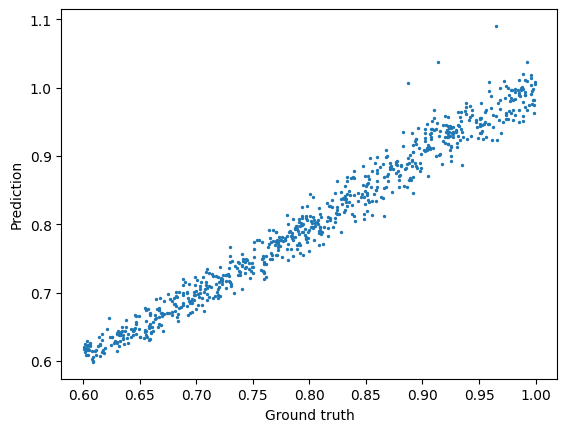

In [26]:
plt.scatter(lbl_cmd, yhat_cmd, s=2)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

plt.show()